In [153]:
%reset
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Machine Learning Engineering Nanodegree
## Project: Onde devo gastar o meu dinheiro?

## Criando bases de dados

O objetivo é criar duas tabelas: a primeira contendo dados do crescimento do IFDM de 2012 em relação a 2008, população das cidades e gastos das cidades em cada uma das subáreas e a segunda tabela contendo os valores de gastos de 2009 a 2012 e os valores de IFDM brutos de 2009 a 2012.

In [154]:
# Importando metodos e pacotes

import numpy as np
import pandas as pd

from scipy import stats
from IPython.display import display

from sklearn.decomposition import PCA

import visuals as vs
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

from pandas.tools.plotting import scatter_matrix

from sets import Set

In [155]:
# Importando bases de dados

# Gastos por funcao no ano de 2009 a 2012
gastos_2012 = pd.read_csv("Data/Despesas por funcao/despesaFuncao2012.csv", encoding="utf-8")
gastos_2011 = pd.read_csv("Data/Despesas por funcao/despesaFuncao2011.csv", encoding="utf-8")
gastos_2010 = pd.read_csv("Data/Despesas por funcao/despesaFuncao2010.csv", encoding="utf-8")
gastos_2009 = pd.read_csv("Data/Despesas por funcao/despesaFuncao2009.csv", encoding="utf-8")

# Codigos de identificacao dos estados e municipios
codigo_municipio = pd.read_csv("Data/Codigo municipal/CodMun2012.csv", encoding='utf-8')
codigo_estado = pd.read_csv("Data/Codigo UF/CodUF2012.csv", encoding='utf-8')

# IFDM por categoria de 2005 a 2013
ifdm_geral_ano_base_2005_2013 = pd.read_csv("Data/IFDM/IFDM_geral_2005-2013.csv", encoding="utf_8", sep=";")
ifdm_saude_ano_base_2005_2013 = pd.read_csv("Data/IFDM/IFDM_saude_2005-2013.csv", encoding="utf_8", sep=";")
ifdm_empregoRenda_ano_base_2005_2013 = pd.read_csv("Data/IFDM/IFDM_empregoRenda_2005-2013.csv", encoding="utf_8", sep=";")
ifdm_educacao_ano_base_2005_2013 = pd.read_csv("Data/IFDM/IFDM_educacao_2005-2013.csv", encoding="utf_8", sep=";")

# Metricas municipais em 2010 (IDH)
municipios_metricas = pd.read_csv("Data/Municipios/municipios.csv", encoding="utf-8", sep=";", decimal=",")

In [156]:
# Criando uma tabela para consulta de cidade e estado
estado_municipio = pd.merge(codigo_municipio, codigo_estado, how='inner', left_on=["CD_UF"], right_on=["CD_UF"])

In [157]:
# Seleciona apenas cidades em comum nas bases

# Unifica cidade e estado para uma unica coluna
def une_cidade_estado(df):
    uf = df["UF"].astype(str)
    mun = df["Cod Mun"].astype(str)
    df["uf_mun"] = uf+"-"+mun
    return df

def troca_codigo_nome(df):
    gastos_ = df.merge(estado_municipio, how='inner', left_on=["Cod Mun", "UF"], right_on=["CD_MUN", "CD_UF"])
    gastos_.drop(['CD_UF', 'CD_MUN', 'UF_x', 'Cod Mun', 'ESTADO'], axis = 1, inplace = True)
    gastos_.rename(columns={'UF_y':'UF', 'MUNICIPIO':'Municipio'}, inplace=True)
    return gastos_

une_cidade_estado(gastos_2009)
une_cidade_estado(gastos_2010)
une_cidade_estado(gastos_2011)
une_cidade_estado(gastos_2012)

# Transforma em Set e busca as cidades em comum a todas bases
int_09_10 = Set(gastos_2009.uf_mun).intersection(Set(gastos_2010.uf_mun))
int_11_12 = Set(gastos_2011.uf_mun).intersection(Set(gastos_2012.uf_mun))
int_todos = int_09_10.intersection(int_11_12)

# Seleciona as cidades remanescentes para cada base
gastos_2012 = gastos_2012[gastos_2012.uf_mun.isin(int_todos)]
gastos_2011 = gastos_2011[gastos_2011.uf_mun.isin(int_todos)]
gastos_2010 = gastos_2010[gastos_2010.uf_mun.isin(int_todos)]
gastos_2009 = gastos_2009[gastos_2009.uf_mun.isin(int_todos)]

# Ordena gastos de 2009 a 2012
gastos_2012 = gastos_2012.sort_values(["uf_mun"])
gastos_2011 = gastos_2011.sort_values(["uf_mun"])
gastos_2010 = gastos_2010.sort_values(["uf_mun"])
gastos_2009 = gastos_2009.sort_values(["uf_mun"])

# Exclui colunas em excesso
gastos_2012.drop(["Desp por Funcao Intra-Orcamentaria","Total Geral da Despesa por Funcao","uf_mun"], axis = 1, inplace = True)
gastos_2011.drop(["Desp por Funcao Intra-Orcamentaria","Total Geral da Despesa por Funcao","uf_mun"], axis = 1, inplace = True)
gastos_2010.drop(["Desp por Funcao Intra-Orcamentaria","Total Geral da Despesa por Funcao","uf_mun"], axis = 1, inplace = True)
gastos_2009.drop(["uf_mun"], axis = 1, inplace = True)

# Alinha os indices dos data frames
gastos_2011 = gastos_2011.set_index(gastos_2012.index)
gastos_2010 = gastos_2010.set_index(gastos_2012.index)
gastos_2009 = gastos_2009.set_index(gastos_2012.index)

# Troca os codigos dos municipios pelos nomes
gastos_2012 = troca_codigo_nome(gastos_2012)
gastos_2011 = troca_codigo_nome(gastos_2011)
gastos_2010 = troca_codigo_nome(gastos_2010)
gastos_2009 = troca_codigo_nome(gastos_2009)

In [158]:
# Coloca os gastos em porcentagem
def percent(df):
    
    uf_cod_mun = df.loc[:,['UF','Municipio']]

    df = df.drop(['UF','Municipio'], axis=1)
    total_gastos = df.pop('Despesas por Funcao')

    df_percent = df.div(total_gastos, axis=0)

    # Remonta tabela de gastos inicial
    df_mun = pd.concat([df, total_gastos, uf_cod_mun], axis=1)

    # Concatena gastos ao municipio
    df_mun_percent = pd.concat([df_percent, uf_cod_mun], axis=1)
    return df_mun_percent

gastos_2012_percent = percent(gastos_2012)
gastos_2011_percent = percent(gastos_2011)
gastos_2010_percent = percent(gastos_2010)
gastos_2009_percent = percent(gastos_2009)

In [159]:
# Filtra apenas os municipios com metricas mais recentes e busca apenas as colunas de interesse
municipio_populacao = municipios_metricas.loc[municipios_metricas['ANO'] == municipios_metricas['ANO'].max(), ['Municipio','UF','POP']]

# Trocando codigo de estado pelo nome do estado em municipio_ 
municipio_populacao = codigo_estado.merge(municipio_populacao, left_on=["CD_UF"], right_on=["UF"])
municipio_populacao.drop(['CD_UF', 'UF_y', 'ESTADO'], axis = 1, inplace = True)
municipio_populacao.rename(columns={'UF_x':'UF', 'POP':'Populacao'}, inplace=True)

display(municipio_populacao.head())

UF              Municipio  Populacao
0  RO  ALTA FLORESTA D'OESTE      24097
1  RO              ARIQUEMES      89766
2  RO                 CABIXI       6303
3  RO                 CACOAL      78141
4  RO             CEREJEIRAS      16942

In [160]:
# Criando tabela de IFDM 
conditions = ['Codigo','Regiao','UF','Municipio']
ifdm = ifdm_geral_ano_base_2005_2013.merge(ifdm_saude_ano_base_2005_2013,on=conditions).merge(ifdm_empregoRenda_ano_base_2005_2013,on=conditions).merge(ifdm_educacao_ano_base_2005_2013,on=conditions)

# Removendo cidades sem algum valor de IFDM em algum ano
ifdm = ifdm.dropna()

In [161]:
def remove_acentos(df, coluna):
    sem_acentos = df[coluna].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    df.loc[:,coluna] = sem_acentos
    return df

def letras_minusculas(df, coluna):
    minusculas = df[coluna].str.lower()
    df.loc[:,coluna] = minusculas
    return df

# remove acentos dos nomes das cidades e coloca em letra minuscula
ifdm = remove_acentos(ifdm, "Municipio")
municipio_populacao = remove_acentos(municipio_populacao, "Municipio")

ifdm = letras_minusculas(ifdm, "Municipio")
municipio_populacao = letras_minusculas(municipio_populacao, "Municipio")

### Criando tabela de gastos acumulados de 2009 a 2012 e diferença de IFDM de 2008 a 2012

In [162]:
# Soma os gastos dos anos
mun = gastos_2012.loc[:,["Municipio","UF"]]

gastos_2012_ = gastos_2012.drop(['UF','Municipio'], axis=1)
gastos_2011_ = gastos_2011.drop(['UF','Municipio'], axis=1)
gastos_2010_ = gastos_2010.drop(['UF','Municipio'], axis=1)
gastos_2009_ = gastos_2009.drop(['UF','Municipio'], axis=1)

gastos_09_12 = gastos_2012_.add(gastos_2011_).add(gastos_2010_).add(gastos_2009_)

gastos_09_12 = pd.concat([mun, gastos_09_12], axis=1)

In [163]:
# Cria tabela de porcentagens de gastos pelo total de gastos
gastos_09_12_mun_percent = percent(gastos_09_12)

In [164]:
# remove acentos dos nomes das cidades e coloca em letra minuscula
gastos_09_12_mun_percent = remove_acentos(gastos_09_12_mun_percent, "Municipio")
gastos_09_12_mun_percent = letras_minusculas(gastos_09_12_mun_percent, "Municipio")

In [165]:
# Calcula diferença do IFDM de 2012 e 2008
ifdm['ifdm_dif_saude'] = ifdm['2012_saude_nota'] - ifdm['2008_saude_nota']
#ifdm['ifdm_dif_empregoRenda'] = ifdm['2012_empregoRenda_nota'] - ifdm['2008_empregoRenda_nota']
ifdm['ifdm_dif_educacao'] = ifdm['2012_educacao_nota'] - ifdm['2008_educacao_nota']
ifdm['ifdm_dif_geral'] = ifdm['2012_geral_nota'] - ifdm['2008_geral_nota']

# Filtra apenas colunas de interesse
ifdm_dif = ifdm[['Municipio','UF','Regiao','ifdm_dif_saude','ifdm_dif_educacao','2012_saude_nota','2012_educacao_nota']]
#,'ifdm_dif_empregoRenda','2012_empregoRenda_nota'

In [166]:
# Adiciona ifdm_dif a tabela de gastos
gastos_ifdm_dif = ifdm_dif.merge(gastos_09_12_mun_percent, on=["Municipio","UF"])

# Renomeia algumas colunas
gastos_ifdm_dif.rename(columns={'Demais Subfuncoes 10':'Demais Subfuncoes Saude','Demais Subfuncoes 12':'Demais Subfuncoes Educacao'}, inplace=True)
#,'Demais Subfuncoes 11':'Demais Subfuncoes Emprego'

# Filtra features relacionadas a investimentos em trabalho, saude e educacao
gastos_ifdm_dif = gastos_ifdm_dif.loc[:,['ifdm_dif_saude','ifdm_dif_educacao','2012_saude_nota','2012_educacao_nota','Regiao','UF','Municipio','Saude','Atencao Basica','Assistencia Hospitalar','Suporte Profilatico','Vigilancia Sanitaria','Vigilancia Epidemiologica','Alimentacao e Nutricao','Demais Subfuncoes Saude','Educacao','Ensino Fundamental','Ensino Medio','Ensino Profissional','Ensino Superior','Educacao Infantil','Educacao de Jovens e Adultos','Educacao Especial','Demais Subfuncoes Educacao']]
#,'ifdm_dif_empregoRenda','2012_empregoRenda_nota','Trabalho','Protecao ao Trabalhador','Relacoes de Trabalho','Empregabilidade','Fomento ao Trabalho','Demais Subfuncoes Emprego'

In [167]:
# Adiciona populacao a tabela de gastos
gastos_ifdm_dif = gastos_ifdm_dif.merge(municipio_populacao, on=["Municipio","UF"])

In [168]:
# Finalizando primeira tabela: Tabela de gastos acumulados na gestao de 2009-2012

# Categoriza o tamanho das cidades pela populacao
gastos_ifdm_dif['Tamanho'] = np.where(gastos_ifdm_dif['Populacao'] < 50000, 'Pequena', 
        np.where(gastos_ifdm_dif['Populacao'] < 100000, 'Media-pequena',
                np.where(gastos_ifdm_dif['Populacao'] < 300000, 'Media',
                        np.where(gastos_ifdm_dif['Populacao'] < 500000, 'Media-grande',
                                np.where(gastos_ifdm_dif['Populacao'] < 1000000, 'Grande', 'Metropole')))))

In [169]:
display(gastos_ifdm_dif.head())

ifdm_dif_saude  ifdm_dif_educacao  2012_saude_nota  2012_educacao_nota  \
0          0.0625             0.0102           0.5759              0.6329   
1          0.0920             0.1406           0.8373              0.7606   
2          0.0371             0.0674           0.6419              0.7462   
3          0.1379             0.0977           0.8258              0.7169   
4          0.0897             0.0443           0.5596              0.7308   

  Regiao  UF              Municipio     Saude  Atencao Basica  \
0  Norte  RO  alta floresta d'oeste  0.273451        0.085496   
1  Norte  RO              ariquemes  0.240095        0.028727   
2  Norte  RO                 cabixi  0.238619        0.062699   
3  Norte  RO                 cacoal  0.260753        0.036536   
4  Norte  RO             cerejeiras  0.245080        0.058779   

   Assistencia Hospitalar      ...        Ensino Fundamental  Ensino Medio  \
0                0.183615      ...                  0.258567      0.000000   
1                0.070513      ...                  0.186091      0.000000   
2                0.169311      ...                  0.272795      0.000000   
3                0.111969      ...                  0.174964      0.000000   
4                0.071014      ...                  0.199923      0.011347   

   Ensino Profissional  Ensino Superior  Educacao Infantil  \
0                  0.0         0.000608           0.009761   
1                  0.0         0.000122           0.012523   
2                  0.0         0.000913           0.020824   
3                  0.0         0.000000           0.040643   
4                  0.0         0.000000           0.022167   

   Educacao de Jovens e Adultos  Educacao Especial  \
0                      0.000000           0.000000   
1                      0.002224           0.000000   
2                      0.000000           0.000000   
3                      0.000000           0.000594   
4                      0.000000           0.000992   

   Demais Subfuncoes Educacao  Populacao        Tamanho  
0                    0.000000      24097        Pequena  
1                    0.133886      89766  Media-pequena  
2                    0.000000       6303        Pequena  
3                    0.016351      78141  Media-pequena  
4                    0.000000      16942        Pequena  

[5 rows x 26 columns]

### Criando tabela de gastos com valores por ano

# Análise descritiva


In [170]:
# Dados
display(gastos_ifdm_dif.head())

ifdm_dif_saude  ifdm_dif_educacao  2012_saude_nota  2012_educacao_nota  \
0          0.0625             0.0102           0.5759              0.6329   
1          0.0920             0.1406           0.8373              0.7606   
2          0.0371             0.0674           0.6419              0.7462   
3          0.1379             0.0977           0.8258              0.7169   
4          0.0897             0.0443           0.5596              0.7308   

  Regiao  UF              Municipio     Saude  Atencao Basica  \
0  Norte  RO  alta floresta d'oeste  0.273451        0.085496   
1  Norte  RO              ariquemes  0.240095        0.028727   
2  Norte  RO                 cabixi  0.238619        0.062699   
3  Norte  RO                 cacoal  0.260753        0.036536   
4  Norte  RO             cerejeiras  0.245080        0.058779   

   Assistencia Hospitalar      ...        Ensino Fundamental  Ensino Medio  \
0                0.183615      ...                  0.258567      0.000000   
1                0.070513      ...                  0.186091      0.000000   
2                0.169311      ...                  0.272795      0.000000   
3                0.111969      ...                  0.174964      0.000000   
4                0.071014      ...                  0.199923      0.011347   

   Ensino Profissional  Ensino Superior  Educacao Infantil  \
0                  0.0         0.000608           0.009761   
1                  0.0         0.000122           0.012523   
2                  0.0         0.000913           0.020824   
3                  0.0         0.000000           0.040643   
4                  0.0         0.000000           0.022167   

   Educacao de Jovens e Adultos  Educacao Especial  \
0                      0.000000           0.000000   
1                      0.002224           0.000000   
2                      0.000000           0.000000   
3                      0.000000           0.000594   
4                      0.000000           0.000992   

   Demais Subfuncoes Educacao  Populacao        Tamanho  
0                    0.000000      24097        Pequena  
1                    0.133886      89766  Media-pequena  
2                    0.000000       6303        Pequena  
3                    0.016351      78141  Media-pequena  
4                    0.000000      16942        Pequena  

[5 rows x 26 columns]

In [171]:
# Descricao dos dados pelo tamanho da cidade
g = gastos_ifdm_dif.groupby('Tamanho')

display(g.describe())

2012_educacao_nota  2012_saude_nota  \
Tamanho                                                    
Grande        count           23.000000        23.000000   
              mean             0.763557         0.836570   
              std              0.122712         0.075541   
              min              0.536900         0.679500   
              25%              0.652550         0.795900   
              50%              0.789400         0.847800   
              75%              0.866900         0.910900   
              max              0.929700         0.938100   
Media         count          184.000000       184.000000   
              mean             0.774731         0.807427   
              std              0.112463         0.098997   
              min              0.526500         0.436800   
              25%              0.686900         0.765850   
              50%              0.787350         0.823800   
              75%              0.864550         0.878675   
              max              0.974300         0.966000   
Media-grande  count           40.000000        40.000000   
              mean             0.772825         0.823953   
              std              0.113910         0.091692   
              min              0.594600         0.599000   
              25%              0.654000         0.771475   
              50%              0.778200         0.856150   
              75%              0.865550         0.886025   
              max              0.969800         0.966300   
Media-pequena count          298.000000       298.000000   
              mean             0.726124         0.729847   
              std              0.130780         0.152740   
              min              0.414400         0.257300   
              25%              0.630675         0.634725   
              50%              0.723600         0.769650   
              75%              0.833150         0.844675   
              max              0.982500         0.979600   
Metropole     count           14.000000        14.000000   
              mean             0.765429         0.832479   
              std              0.098218         0.083224   
              min              0.603100         0.679100   
              25%              0.693950         0.786300   
              50%              0.755250         0.844500   
              75%              0.836100         0.882250   
              max              0.906400         0.964000   
Pequena       count         3884.000000      3884.000000   
              mean             0.724122         0.713557   
              std              0.121722         0.148808   
              min              0.271400         0.184100   
              25%              0.637650         0.619575   
              50%              0.734350         0.736600   
              75%              0.811525         0.827400   
              max              1.000000         1.000000   

                     Alimentacao e Nutricao  Assistencia Hospitalar  \
Tamanho                                                               
Grande        count            2.300000e+01               23.000000   
              mean             7.958389e-04                0.139881   
              std              2.264456e-03                0.062634   
              min              0.000000e+00                0.044776   
              25%              0.000000e+00                0.087184   
              50%              0.000000e+00                0.134551   
              75%              1.866437e-04                0.178486   
              max              1.032140e-02                0.266283   
Media         count            1.840000e+02              184.000000   
              mean             2.087602e-03                0.089288   
              std              5.780833e-03                0.067075   
              min              0.000000e+00                0.000000   
              25%         

In [172]:
# Utilizacao de cidades medias, media-grandes, grandes e metropoles no estudo
cidades_medias = gastos_ifdm_dif.loc[gastos_ifdm_dif['Tamanho'].isin(['Media'])]
n_cidades = len(cidades_medias)
print "Numero de cidades na base: {}".format(n_cidades)

Numero de cidades na base: 184


In [173]:
print "Cidades por estado: "
print cidades_medias['UF'].value_counts()

Cidades por estado: 
SP    51
MG    17
RJ    15
RS    14
PR    13
BA    11
SC     9
PE     8
CE     6
MA     6
ES     5
PA     5
GO     5
MT     3
MS     3
TO     2
RN     2
PB     2
SE     1
RR     1
PI     1
RO     1
AL     1
AP     1
AM     1
Name: UF, dtype: int64


In [174]:
print "Cidades por regiao: "
print cidades_medias['Regiao'].value_counts()

display(cidades_medias.head())

Cidades por regiao: 
Sudeste         88
Nordeste        38
Sul             36
Centro-Oeste    11
Norte           11
Name: Regiao, dtype: int64


ifdm_dif_saude  ifdm_dif_educacao  2012_saude_nota  2012_educacao_nota  \
11          -0.0378             0.0606           0.6752              0.6866   
87           0.0650             0.1238           0.6874              0.7602   
98           0.0346             0.0867           0.7906              0.7025   
100          0.1133             0.0718           0.5925              0.6163   
113          0.0552             0.0823           0.4771              0.5987   

    Regiao  UF   Municipio     Saude  Atencao Basica  Assistencia Hospitalar  \
11   Norte  RO   ji-parana  0.304825        0.048542                0.108435   
87   Norte  AM   parintins  0.244177        0.169681                0.069169   
98   Norte  RR   boa vista  0.202828        0.131149                0.061132   
100  Norte  PA  abaetetuba  0.220174        0.072683                0.101183   
113  Norte  PA    braganca  0.200949        0.101283                0.026003   

      ...     Ensino Fundamental  Ensino Medio  Ensino Profissional  \
11    ...               0.181778      0.000000             0.000000   
87    ...               0.320053      0.004295             0.000023   
98    ...               0.155425      0.000000             0.000000   
100   ...               0.405891      0.000000             0.000000   
113   ...               0.333400      0.001833             0.000000   

     Ensino Superior  Educacao Infantil  Educacao de Jovens e Adultos  \
11          0.000362           0.014095                      0.000000   
87          0.000340           0.055432                      0.000000   
98          0.000000           0.025647                      0.000979   
100         0.000053           0.003681                      0.010452   
113         0.000031           0.039123                      0.003245   

     Educacao Especial  Demais Subfuncoes Educacao  Populacao  Tamanho  
11            0.000599                    0.003540     115896    Media  
87            0.000000                    0.007100     101218    Media  
98            0.000245                    0.039438     281538    Media  
100           0.000000                    0.015534     140055    Media  
113           0.000012                    0.087360     112709    Media  

[5 rows x 26 columns]

In [175]:
# Separa so os gastos de cada cidade
gastos = cidades_medias.copy()
gastos.drop(['ifdm_dif_saude','ifdm_dif_educacao','2012_saude_nota','2012_educacao_nota','Regiao','UF','Municipio','Tamanho','Populacao'], axis = 1, inplace = True)
#,'ifdm_dif_empregoRenda','2012_empregoRenda_nota'

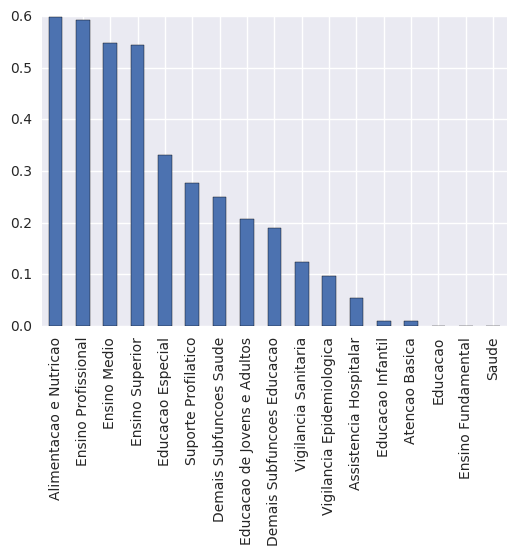

In [176]:
total_ocorrencias = gastos[gastos == 0].count()
porcentagem_ocorrencias = total_ocorrencias/n_cidades
porcentagem_ocorrencias = porcentagem_ocorrencias.sort_values(ascending=False)

porcentagem_ocorrencias.plot.bar();

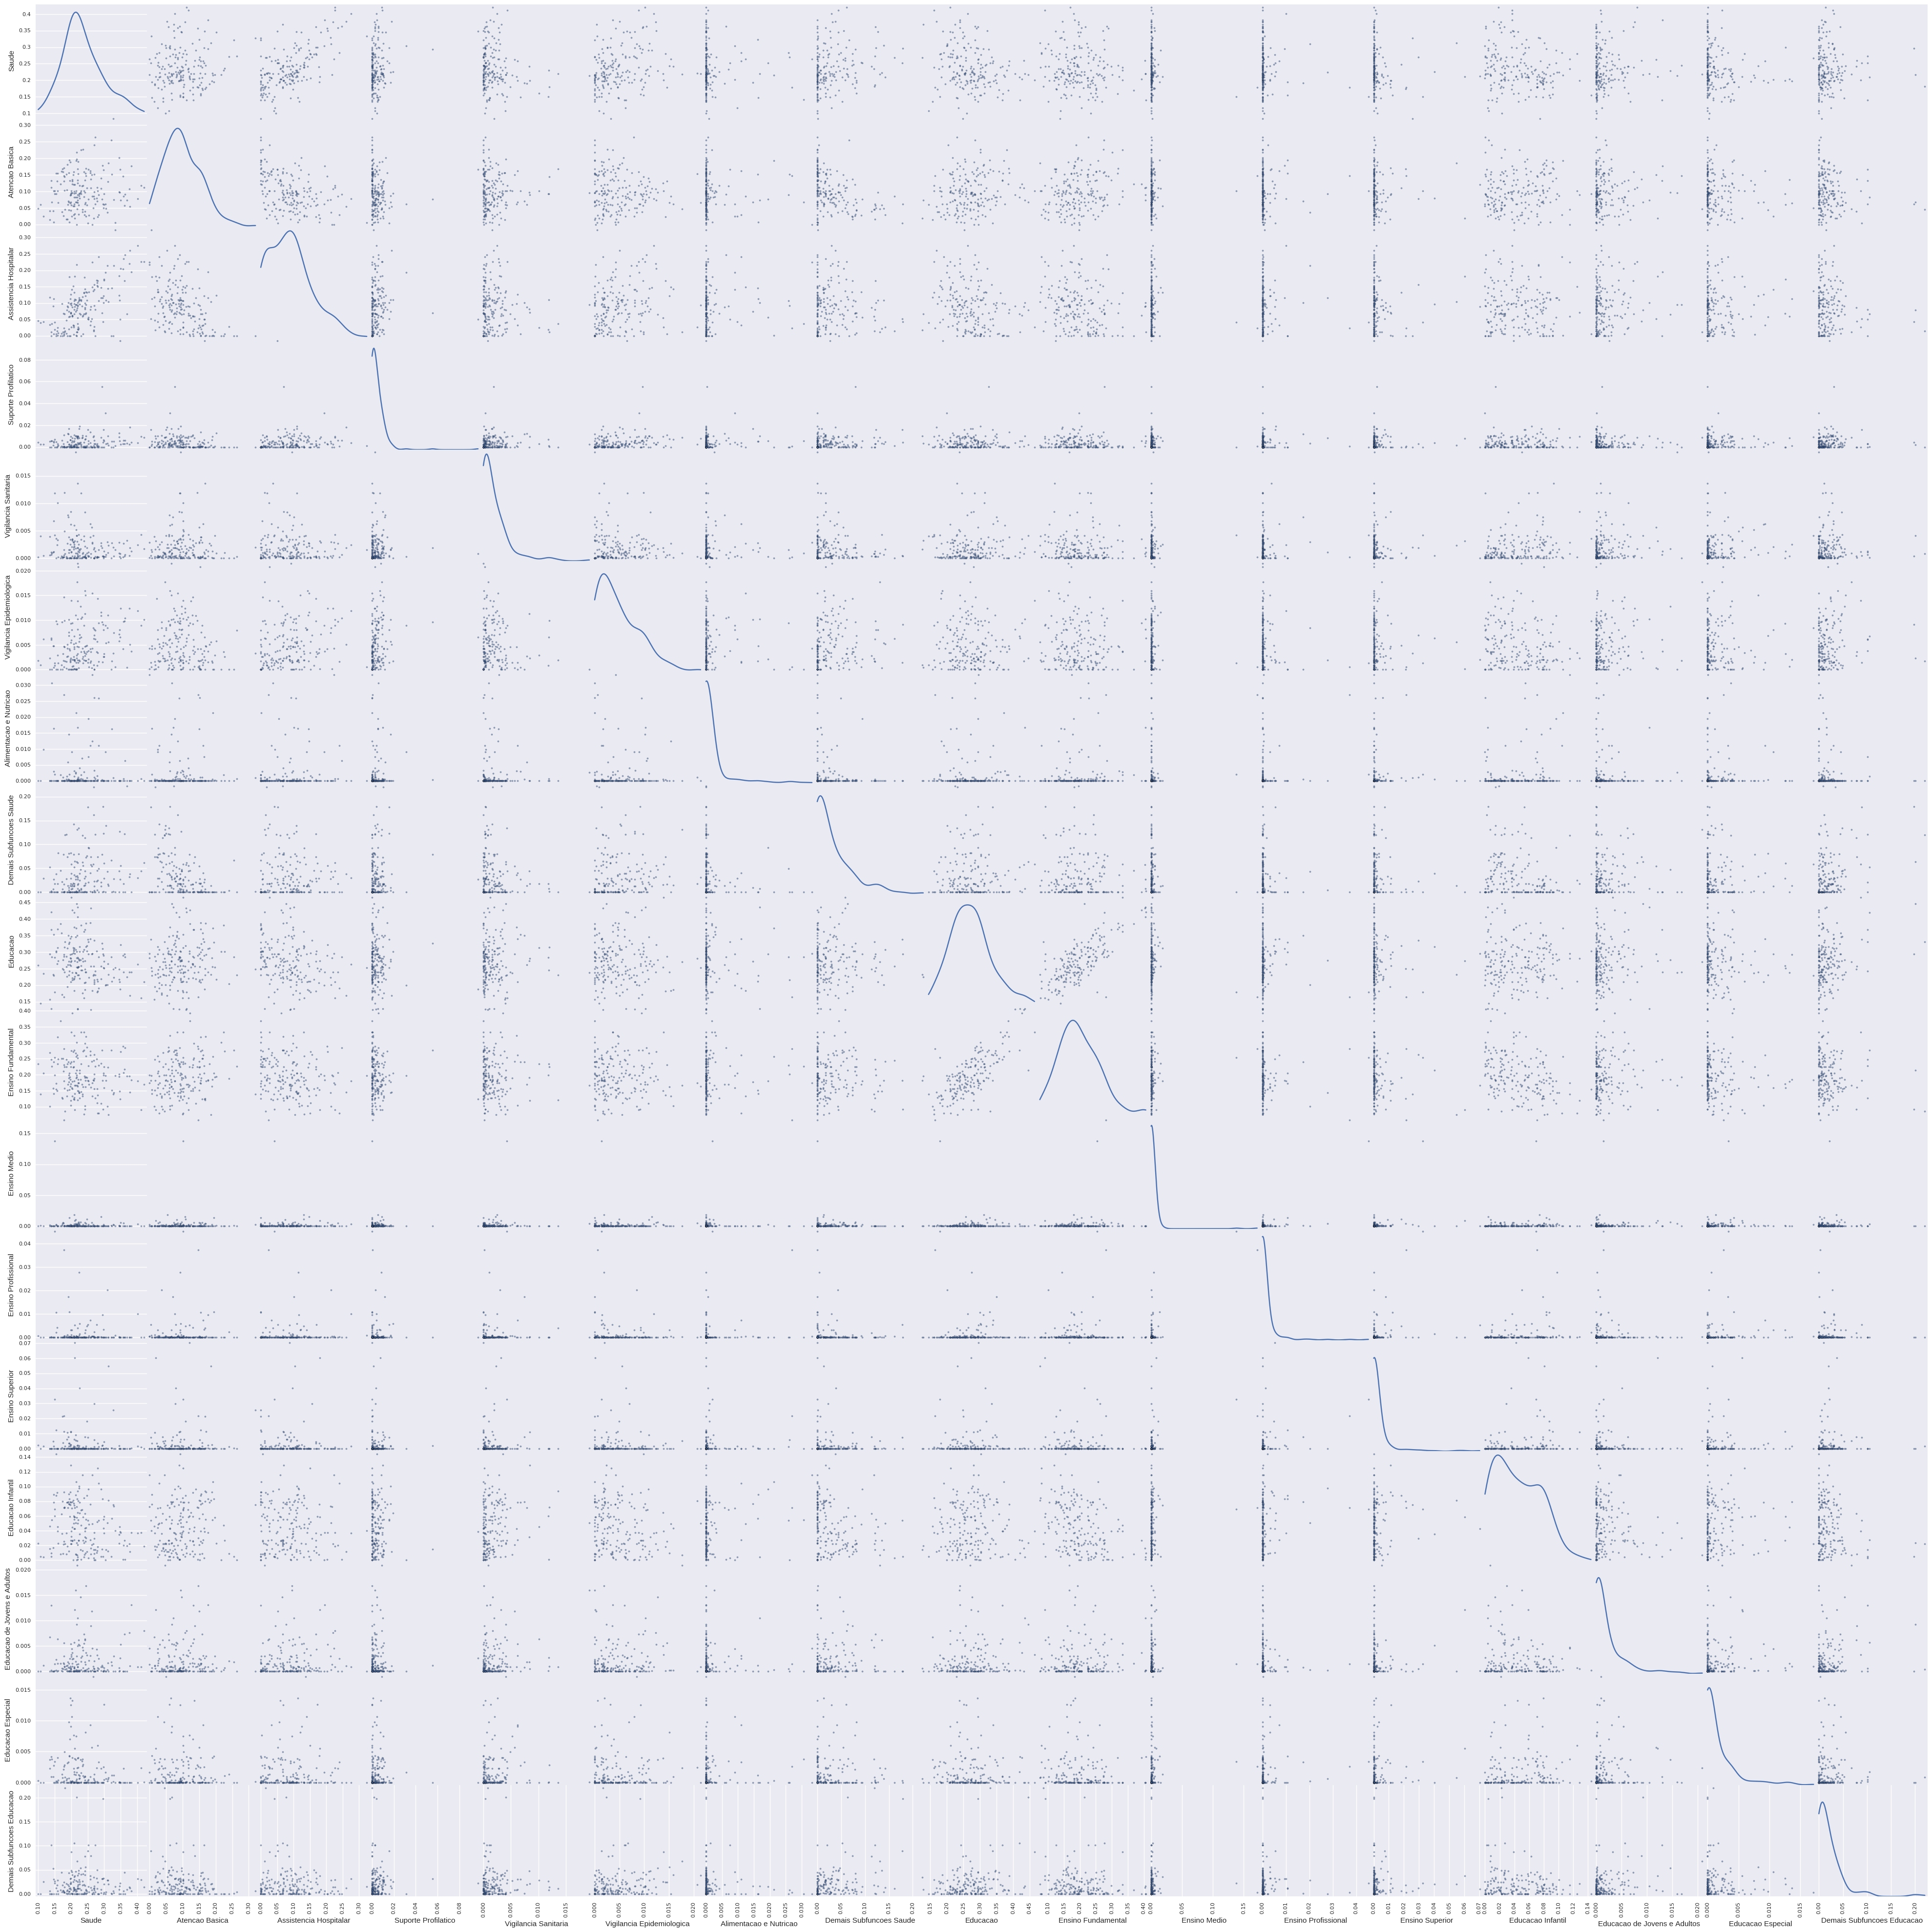

In [177]:
# Produz um scatterplot para cada par de features
scatter_matrix(gastos, figsize=(50, 50), diagonal='kde');

## Pré-processamento

In [178]:
# Encontra cidades que nao descreveram os gastos de acordo com o esperado e devem ser removidas da pesquisa
#para_remover = gastos[gastos.Trabalho == 0.0].index
para_remover = (gastos[gastos.Educacao == 0.0].index)
para_remover.append(gastos[gastos.Saude == 0.0].index)
len(para_remover)

0

In [179]:
# Remove cidades das bases utilizadas
cidades_medias = cidades_medias[~cidades_medias.index.isin(para_remover)]
gastos = gastos[~gastos.index.isin(para_remover)]
len(cidades_medias)

184

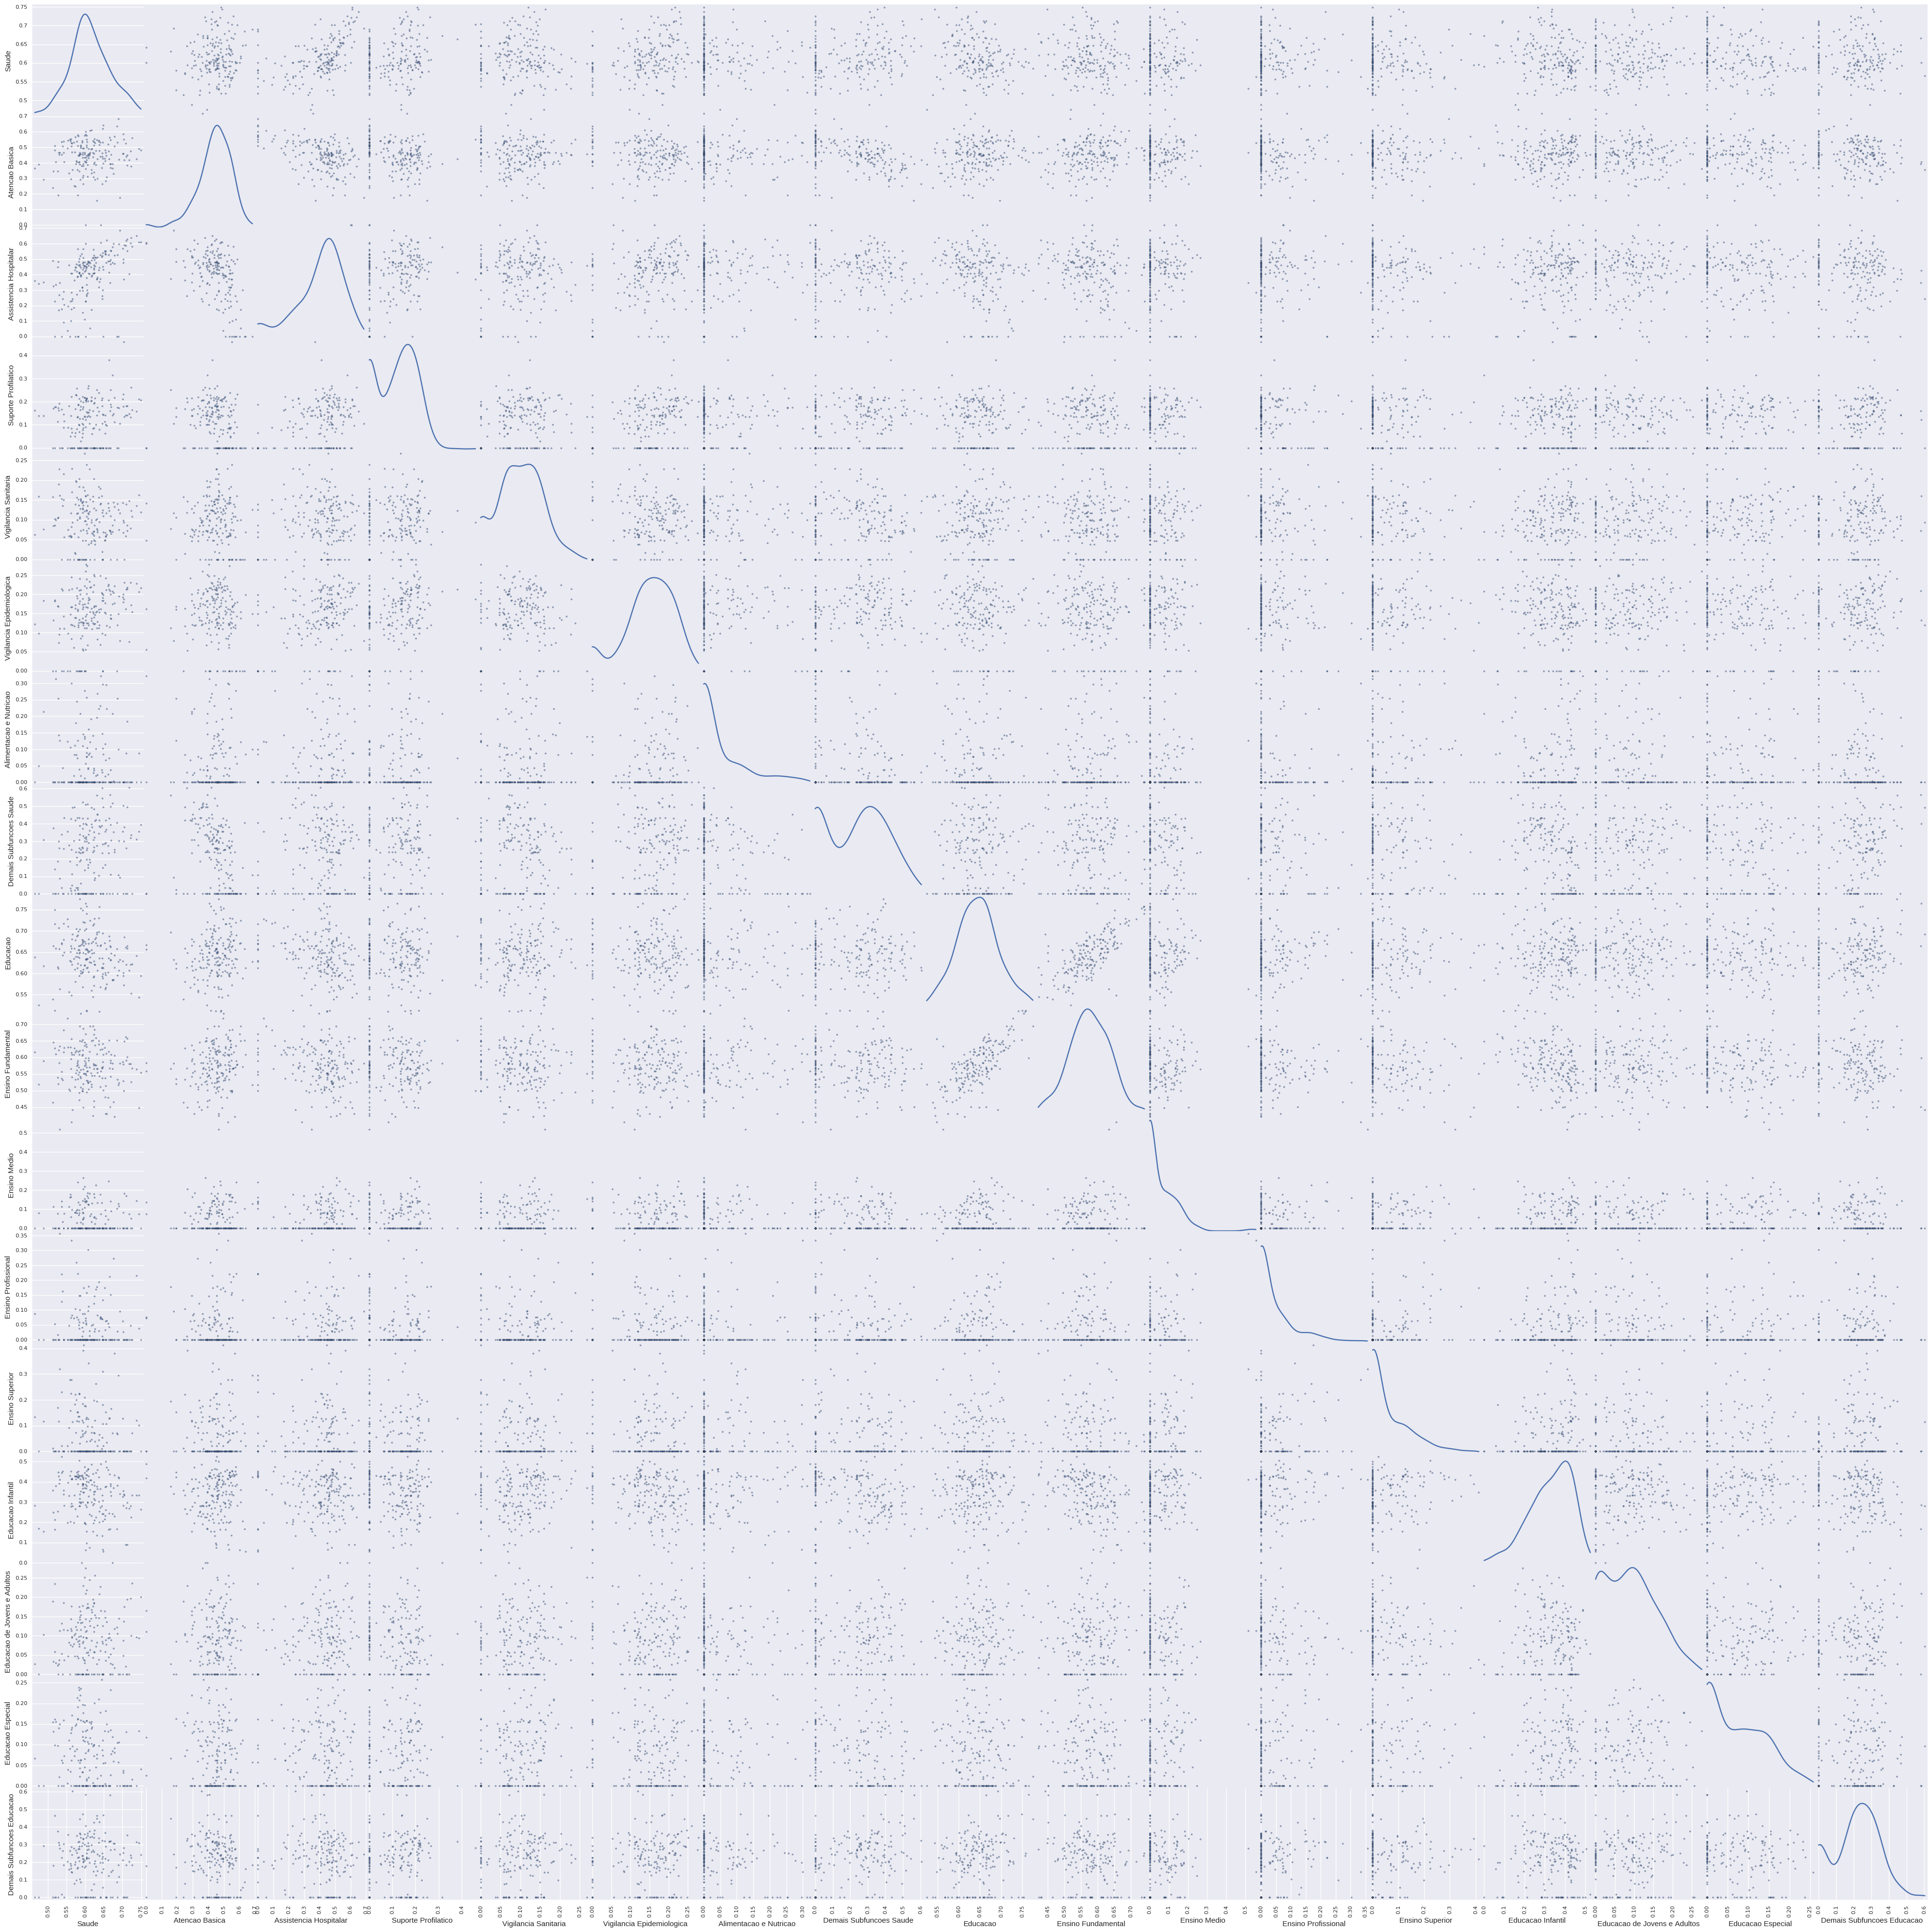

In [180]:
# Transforma os dados utilizando a raiz cubica
cbrt_gastos = gastos
cbrt_gastos = np.cbrt(gastos)

# Produz um scatterplot para cada par de features
pd.scatter_matrix(cbrt_gastos, figsize = (50,50), diagonal = 'kde');

In [181]:
# Remove Trabalho, Educacao e Saude
cbrt_gastos.drop(['Saude', 'Educacao'], axis = 1, inplace = True)#, 'Trabalho'

# Agrupamentos por gastos

## Maiores cidades do Brasil

In [182]:
# Aplica o PCA. Numero de componentes igual ao numero de colunas
pca = PCA(n_components=len(cbrt_gastos.columns))
pca.fit(cbrt_gastos)

PCA(copy=True, n_components=15, whiten=False)

Dimensao  Variancia
0          1   0.268098
1          2   0.182387
2          3   0.108585
3          4   0.078166
4          5   0.057597
5          6   0.052422
6          7   0.046299
7          8   0.040139
8          9   0.035800
9         10   0.031308
10        11   0.025815
11        12   0.022044
12        13   0.019036
13        14   0.017165
14        15   0.015139

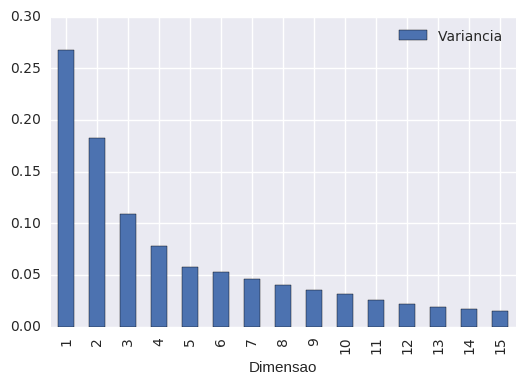

In [183]:
# Quantidade de variancia de cada componente principal
dimensoes = range(1,len(pca.components_)+1)
d = {'Variancia':pca.explained_variance_ratio_, 'Dimensao':dimensoes}
componentes = pd.DataFrame(d);

display(componentes);
componentes.plot.bar(x='Dimensao',y='Variancia');

In [184]:
# Principais atributos para cada componente
atributos_por_componente = pd.DataFrame(np.round(pca.components_, 4), columns = cbrt_gastos.keys())
atributos_por_componente.index = dimensoes
cor_area = ['g','g','g','g','g','g','g','r','r','r','r','r','r','r','r'] #,'b','b','b','b','b'

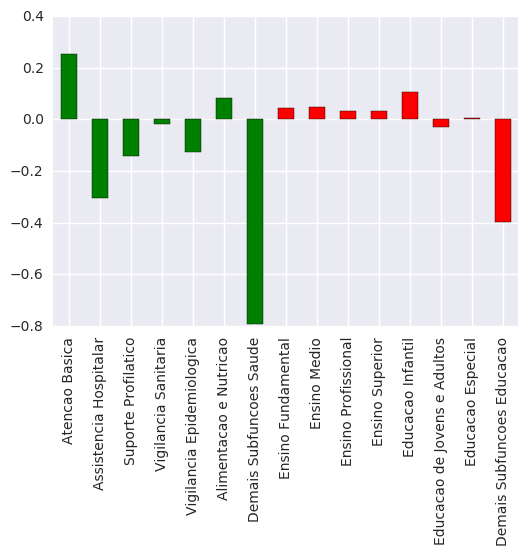

In [185]:
# Componente 1
atributos_por_componente.iloc[0,:].plot.bar(color=cor_area);

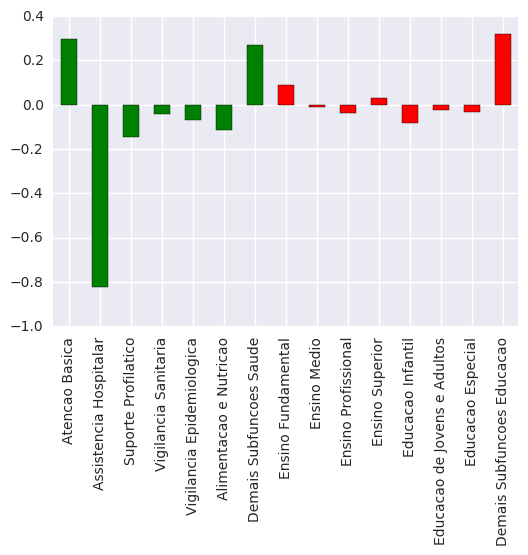

In [186]:
# Componente 2
atributos_por_componente.iloc[1,:].plot.bar(color=cor_area);

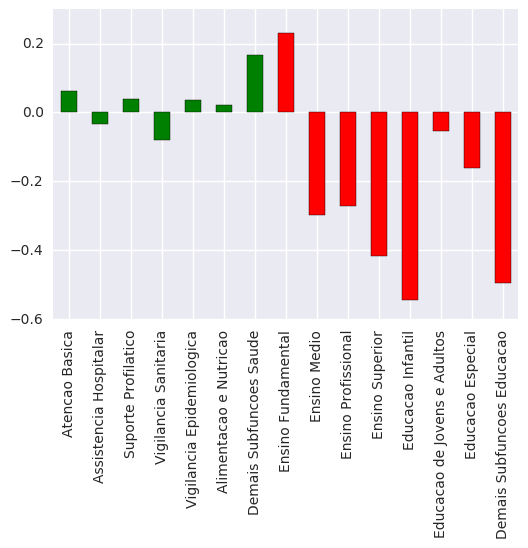

In [187]:
# Componente 3
atributos_por_componente.iloc[2,:].plot.bar(color=cor_area);

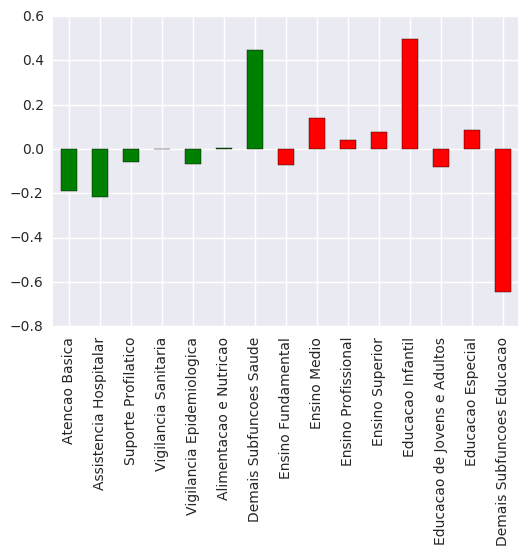

In [188]:
# Componente 4
atributos_por_componente.iloc[3,:].plot.bar(color=cor_area);

In [189]:
# Aplica o PCA e faz o fitting dos dados utilizando quatro dimensoes
pca = PCA(n_components=4)
pca.fit(cbrt_gastos)

# Transforma os dados utilizando o pca
dados_reduzidos = pca.transform(cbrt_gastos)

# Cria um dataframe para os dados em dimensoes reduzidas
dados_reduzidos = pd.DataFrame(dados_reduzidos, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4'])

In [190]:
display(dados_reduzidos.head())

Dimension 1  Dimension 2  Dimension 3  Dimension 4
0    -0.271033    -0.016016     0.141955     0.120380
1     0.178302     0.012225    -0.025955    -0.035991
2     0.011895     0.086806    -0.017373    -0.121339
3    -0.042349    -0.072481     0.154141    -0.183717
4    -0.176090     0.235094    -0.057965    -0.065734

In [191]:
# Cria cluster e compara mostra os silhouettes
def cluster_silhouette(n_clusters, data):

    clusterer = KMeans(n_clusters, random_state=0)
    clusterer = clusterer.fit(data)

    preds = clusterer.predict(data)

    score = silhouette_score(data, preds)

    return (score, clusterer)

for x in range(2, 10):
    print "number of clusters: {}, silhouette score: {}".format(x, cluster_silhouette(x, dados_reduzidos)[0])

number of clusters: 2, silhouette score: 0.314161260199
number of clusters: 3, silhouette score: 0.305631418334
number of clusters: 4, silhouette score: 0.214596158612
number of clusters: 5, silhouette score: 0.219912659921
number of clusters: 6, silhouette score: 0.212035515471
number of clusters: 7, silhouette score: 0.226075582362
number of clusters: 8, silhouette score: 0.21659227273
number of clusters: 9, silhouette score: 0.241621289426


In [192]:
# Atribui cada ponto a um cluster

# Melhor cluster de acordo com silhouette
grupos = cluster_silhouette(3, dados_reduzidos)[1]

# Atribui os pontos aos clusters
preds = grupos.predict(dados_reduzidos)

# Acha o centro dos clusters
centros = grupos.cluster_centers_

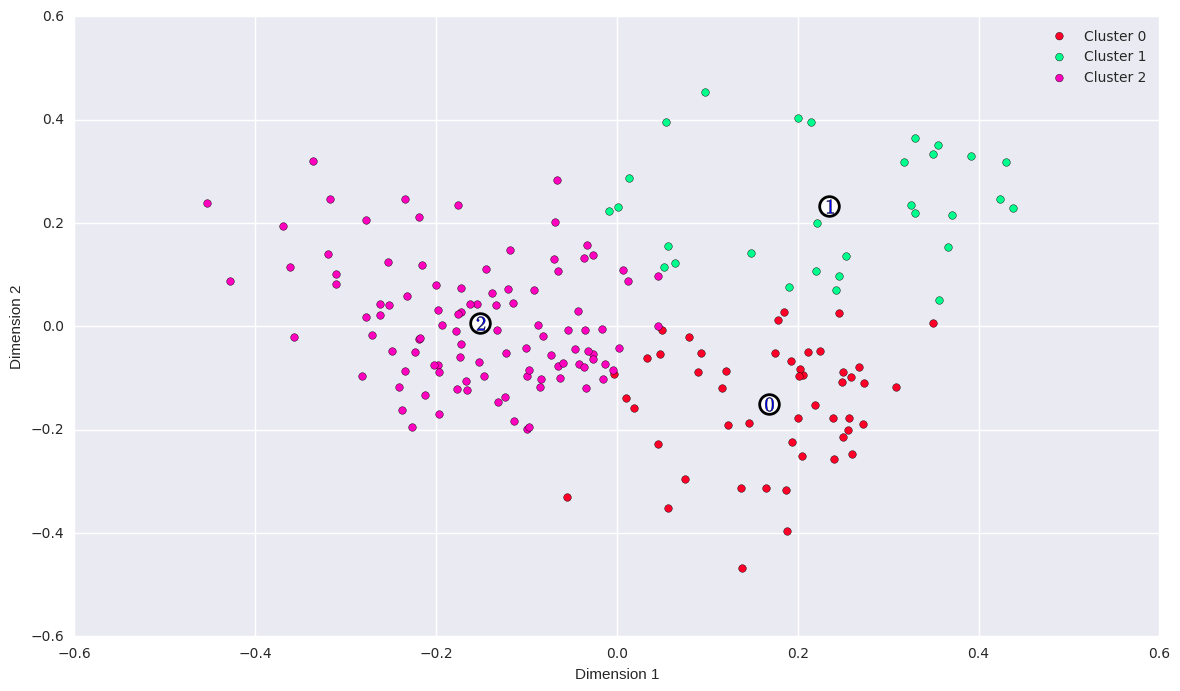

In [193]:
# Display the results of the clustering from implementation
vs.cluster_results(dados_reduzidos, preds, centros);

In [194]:
# Adiciona cluster a tabela original de cidades
cidades_medias.insert(0, 'Grupo', preds)

## Analise de grupos

### Descricao dos grupos

In [195]:
caracteristicas_educacao = ['Grupo','Ensino Fundamental','Ensino Medio','Ensino Profissional','Ensino Superior','Educacao Infantil','Educacao de Jovens e Adultos','Educacao Especial','Demais Subfuncoes Educacao',]
caracteristicas_saude = ['Grupo','Atencao Basica','Assistencia Hospitalar','Suporte Profilatico','Vigilancia Sanitaria','Vigilancia Epidemiologica','Alimentacao e Nutricao','Demais Subfuncoes Saude']
caracteristicas_empregoRenda = ['Grupo','Protecao ao Trabalhador','Relacoes de Trabalho','Empregabilidade','Fomento ao Trabalho','Demais Subfuncoes Emprego']

In [196]:
# Analise de ifdm
cidade_ifdm_grupo = cidades_medias.loc[:,['ifdm_dif_saude',
 #'ifdm_dif_empregoRenda',
 'ifdm_dif_educacao',
 'Regiao',
 'UF', 'Municipio',
 'Grupo']]

cidade_ifdm_dif_grupo = cidades_medias.loc[:,['2012_saude_nota',
 #'2012_empregoRenda_nota',
 '2012_educacao_nota',
 'Regiao',
 'UF', 'Municipio',
 'Grupo']]


In [197]:
# Cria grafico de barras com legendas por fora da figura
def grafico_barras(df, titulo):
    f = plt.figure()
    plt.title(titulo)
    df.plot(kind='bar', ax=f.gca())
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

In [198]:
# Tamanho das cidades dos grupos
tam_grupo = cidades_medias.loc[:,['Tamanho','Grupo']]
for grupo in tam_grupo.Grupo.unique():
    print "Grupo: {}".format(grupo);
    display(tam_grupo[tam_grupo.Grupo == grupo].Tamanho.value_counts());


Grupo: 2


Media    103
Name: Tamanho, dtype: int64

Grupo: 0


Media    51
Name: Tamanho, dtype: int64

Grupo: 1


Media    30
Name: Tamanho, dtype: int64

Atencao Basica  Assistencia Hospitalar  Suporte Profilatico  \
Grupo                                                                
0            0.098894                0.119396             0.004124   
1            0.176400                0.006550             0.001497   
2            0.078157                0.098479             0.005778   

       Vigilancia Sanitaria  Vigilancia Epidemiologica  \
Grupo                                                    
0                  0.002160                   0.003208   
1                  0.001696                   0.003453   
2                  0.001945                   0.006250   

       Alimentacao e Nutricao  Demais Subfuncoes Saude  
Grupo                                                   
0                    0.004059                 0.001315  
1                    0.001051                 0.008432  
2                    0.001413                 0.056451

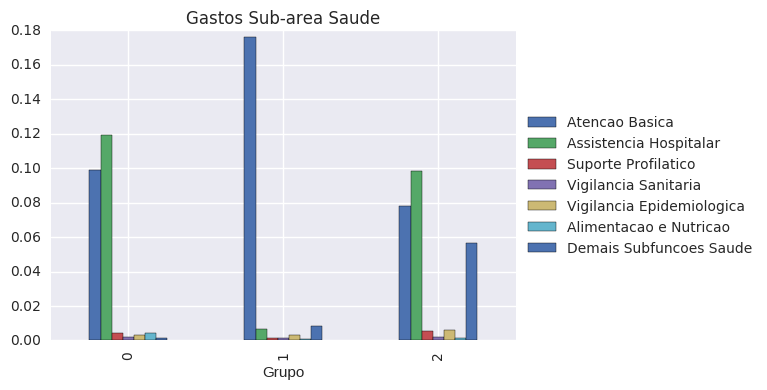

In [199]:
# Gastos das cidades em saude
saude_grupo = cidades_medias.loc[:,caracteristicas_saude]
sg_f = saude_grupo.groupby('Grupo').mean();
display(sg_f)
    
grafico_barras(sg_f, "Gastos Sub-area Saude");

Ensino Fundamental  Ensino Medio  Ensino Profissional  Ensino Superior  \
Grupo                                                                           
0                0.188916      0.007082             0.003263         0.004669   
1                0.227821      0.001136             0.001042         0.002752   
2                0.196967      0.001185             0.000663         0.002354   

       Educacao Infantil  Educacao de Jovens e Adultos  Educacao Especial  \
Grupo                                                                       
0               0.056631                      0.002343           0.001776   
1               0.053786                      0.001340           0.000952   
2               0.036684                      0.002220           0.001771   

       Demais Subfuncoes Educacao  
Grupo                              
0                        0.007721  
1                        0.014291  
2                        0.030433

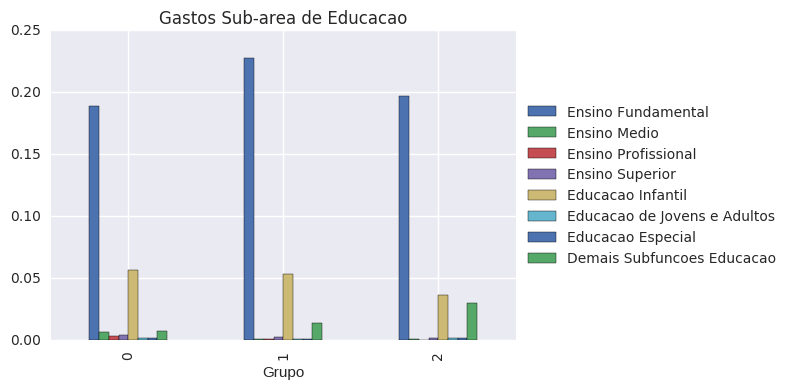

In [200]:
# Gastos das cidades em educacao
educacao_grupo = cidades_medias.loc[:,caracteristicas_educacao]
sg_e = educacao_grupo.groupby('Grupo').mean();
display(sg_e)

grafico_barras(sg_e, "Gastos Sub-area de Educacao");

In [201]:
# Busca centroides (pontos mais representativos) dos grupos

# Transformacao invesa
centros_reais_cbrt = pca.inverse_transform(centros)
centros_reais = np.power(centros_reais_cbrt,3)

# Display the true centers
segments = ['Centroide {}'.format(i) for i in range(0,len(centros_reais))]
centros_reais = pd.DataFrame(centros_reais, columns = cbrt_gastos.keys())
centros_reais.index = segments
display(centros_reais)

Atencao Basica  Assistencia Hospitalar  Suporte Profilatico  \
Centroide 0        0.086226                0.108338             0.001513   
Centroide 1        0.185454                0.002440             0.000119   
Centroide 2        0.066562                0.084207             0.002580   

             Vigilancia Sanitaria  Vigilancia Epidemiologica  \
Centroide 0              0.001107                   0.002576   
Centroide 1              0.000578                   0.001034   
Centroide 2              0.000995                   0.004527   

             Alimentacao e Nutricao  Demais Subfuncoes Saude  \
Centroide 0                0.000533                 0.000076   
Centroide 1                0.000086                 0.001374   
Centroide 2                0.000051                 0.043939   

             Ensino Fundamental  Ensino Medio  Ensino Profissional  \
Centroide 0            0.182516      0.000331             0.000200   
Centroide 1            0.227853      0.000235             0.000056   
Centroide 2            0.187423      0.000102             0.000042   

             Ensino Superior  Educacao Infantil  Educacao de Jovens e Adultos  \
Centroide 0         0.000347           0.046446                      0.000708   
Centroide 1         0.000366           0.035969                      0.000419   
Centroide 2         0.000164           0.029287                      0.000778   

             Educacao Especial  Demais Subfuncoes Educacao  
Centroide 0           0.000513                    0.001604  
Centroide 1           0.000277                    0.005819  
Centroide 2           0.000342                    0.019071

Saude  Educacao
Grupo                    
0      0.232728  0.256487
1      0.199079  0.303120
2      0.248473  0.272278

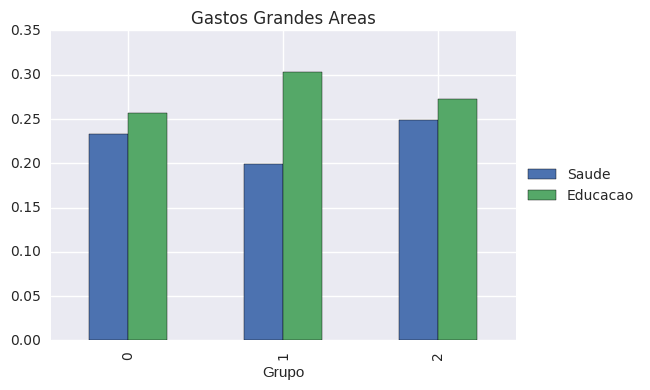

In [202]:
saude_grupo = cidades_medias.loc[:,['Grupo','Saude','Educacao']] #,'Trabalho'
sg_ste = saude_grupo.groupby('Grupo').mean();
display(sg_ste)
    
grafico_barras(sg_ste, "Gastos Grandes Areas");

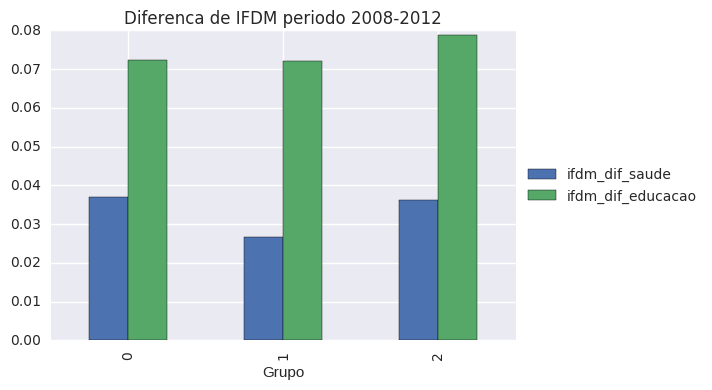

In [203]:
ifdm_grupos = cidade_ifdm_grupo.groupby('Grupo').mean();

grafico_barras(ifdm_grupos, "Diferenca de IFDM periodo 2008-2012");

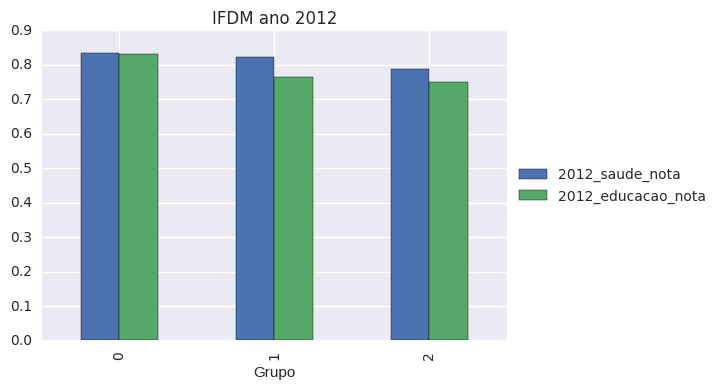

In [204]:
ifdm_dif_grupos = cidade_ifdm_dif_grupo.groupby('Grupo').mean();
grafico_barras(ifdm_dif_grupos, "IFDM ano 2012");

### Descrição dos representantes dos grupos

In [205]:
# Busca cidades destaque em cada grupo

# retorna o maior valor de uma feature e a cidade que a detem
def maior_valor(x, col):
    max_value = x[col].max()
    mun = x[x[col] == max_value].loc[:,["UF","Municipio"]]
    mun["Crescimento"] = max_value
    return mun
    
# Maior ganho em saude
print "Cidades que mais cresceram em Saude: "
display(cidades_medias.groupby("Grupo").apply(maior_valor, "ifdm_dif_saude"));
    
# Maior ganho em educacao
print "Cidades que mais cresceram em educacao: "
display(cidades_medias.groupby("Grupo").apply(maior_valor, "ifdm_dif_educacao"));

# Maior ganho em renda
#print "Cidades que mais cresceram em Emprego e Renda: "
#display(cidades_medias.groupby("Grupo").apply(maior_valor, "ifdm_dif_empregoRenda"));

Cidades que mais cresceram em Saude: 


UF           Municipio  Crescimento
Grupo                                          
0     1406  BA           barreiras       0.2117
1     1850  MG  coronel fabriciano       0.1397
2     2822  SP        praia grande       0.1517

Cidades que mais cresceram em educacao: 


UF Municipio  Crescimento
Grupo                                
0     4344  GO  luziania       0.1624
1     3434  SC  criciuma       0.1305
2     1432  BA  camacari       0.2960

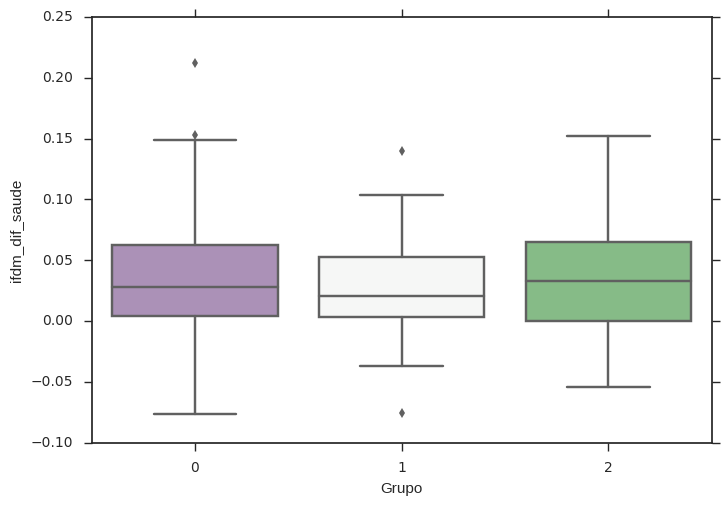

In [223]:
# Boxplot crescimento das cidades em saude por grupos no periodo de 2009 a 2012
sns.boxplot(data=cidades_medias, x="Grupo", y="ifdm_dif_saude", palette="PRGn");

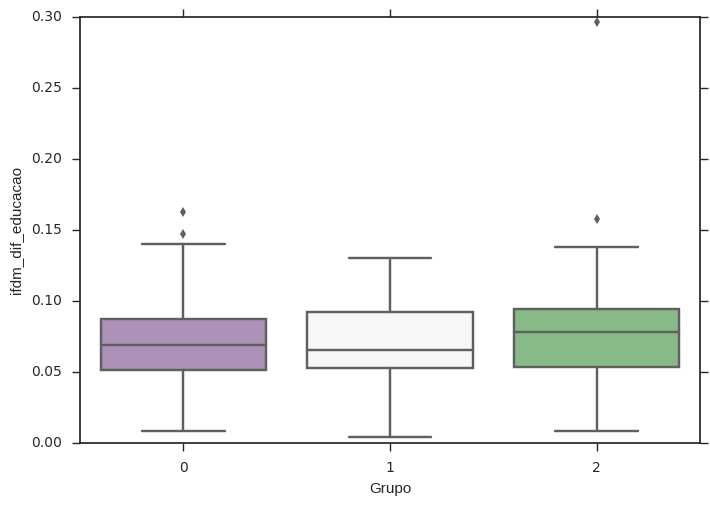

In [222]:
# Boxplot crescimento das cidades em educacao por grupos no periodo de 2009 a 2012
sns.boxplot(data=cidades_medias, x="Grupo", y="ifdm_dif_educacao", palette="PRGn");

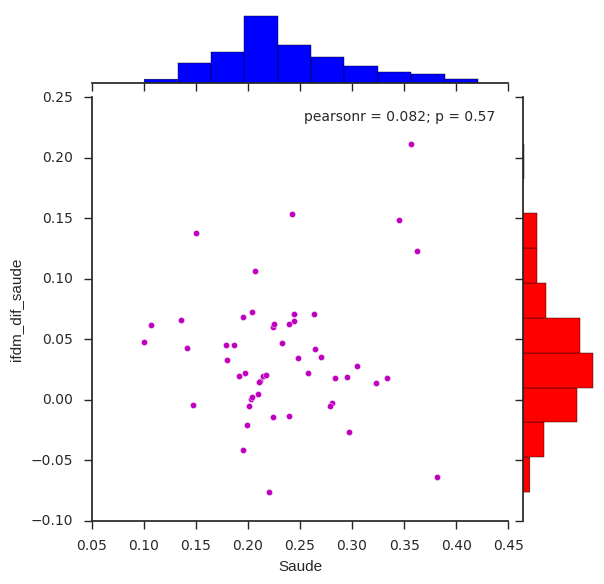

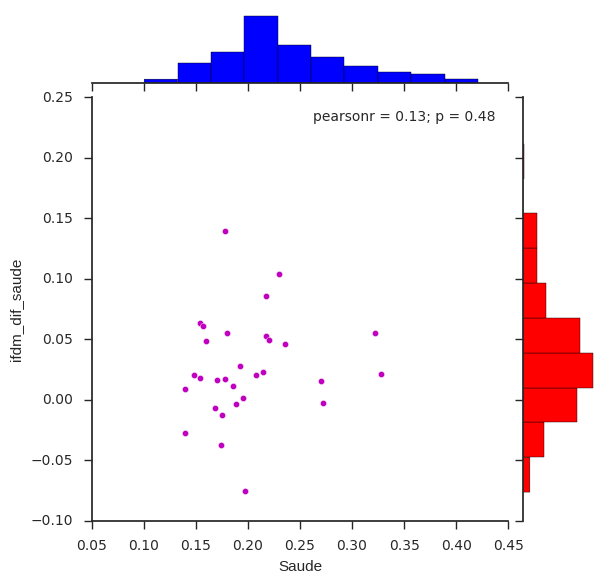

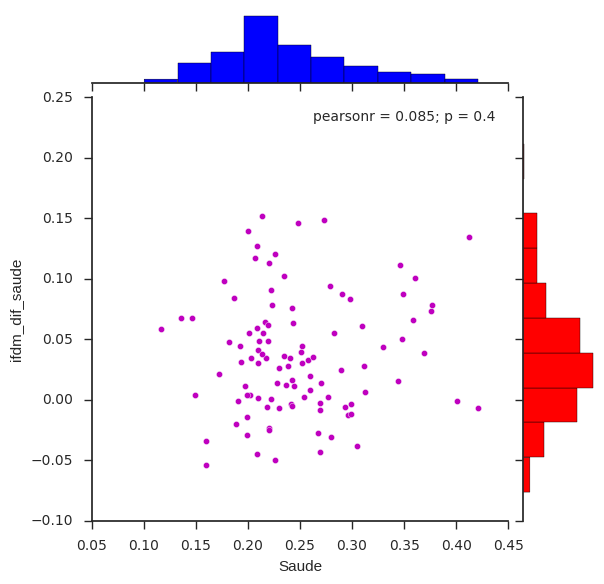

In [266]:
# Plota grafico de correlacao saude x ifdm
def grafico_correlacao(x, y, grupo):

    df = cidades_medias.loc[cidades_medias['Grupo'] == grupo,[x,y]]
    
    g = sns.JointGrid(x, y, data=df)
    g = g.plot_joint(plt.scatter, color="m", edgecolor="white")
    _ = g.ax_marg_x.hist(cidades_medias[x], color="b")
    _ = g.ax_marg_y.hist(cidades_medias[y], color="r", orientation="horizontal")
    g = g.annotate(stats.pearsonr)

grafico_correlacao("Saude", "ifdm_dif_saude", 0);
grafico_correlacao("Saude", "ifdm_dif_saude", 1);
grafico_correlacao("Saude", "ifdm_dif_saude", 2);

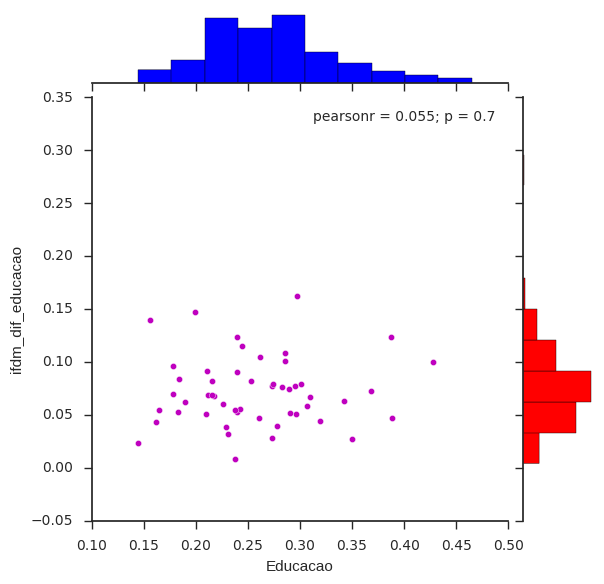

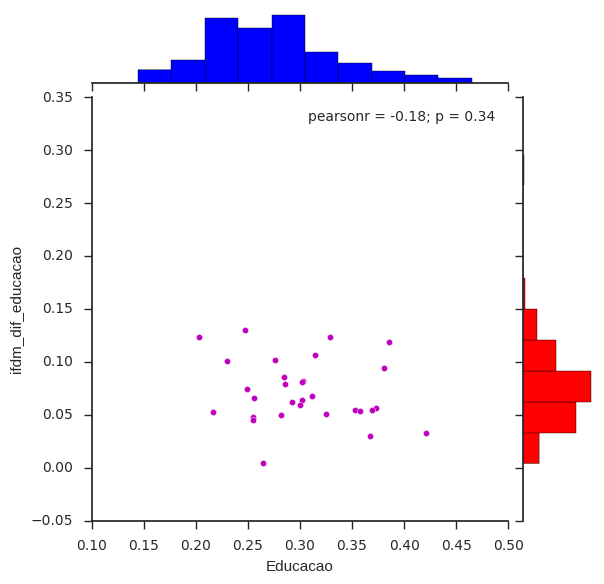

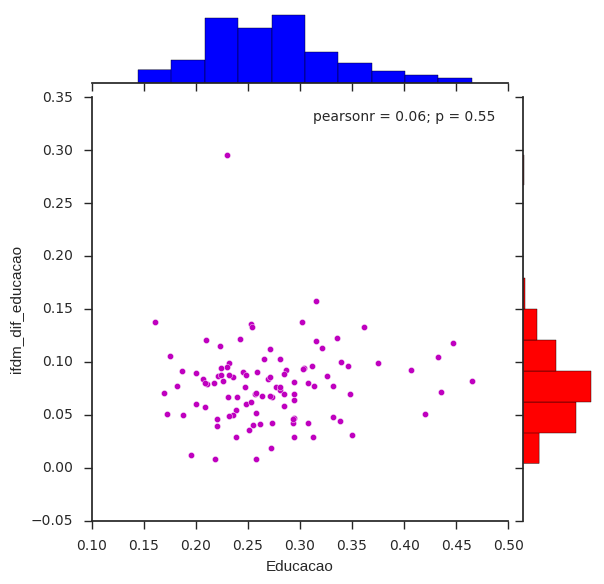

In [267]:
# Plota grafico de correlacao educacao x ifdm educacao

grafico_correlacao("Educacao", "ifdm_dif_educacao", 0);
grafico_correlacao("Educacao", "ifdm_dif_educacao", 1);
grafico_correlacao("Educacao", "ifdm_dif_educacao", 2);

## HEADING 